#**Checking the GPU**

In [47]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0373041e-8366-fb0f-bf9a-01628fe7eea8)


#**Getting data**

In [48]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds 

2.9.2


In [49]:
(train_data,test_data), ds_info= tfds.load(name="food101",
                                           split=["train","validation"],
                                           as_supervised=True,
                                           with_info=True,
                                           shuffle_files=True)

In [50]:
print(ds_info.features)
classes=ds_info.features["label"].names

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})


In [51]:
for image, label in train_data.take(1):
    print(image)
    print(label)
    print(classes[int(label)])

tf.Tensor(
[[[ 93  34  40]
  [ 93  34  40]
  [ 94  35  41]
  ...
  [ 52  15  23]
  [ 52  15  23]
  [ 52  15  23]]

 [[ 93  34  40]
  [ 93  34  40]
  [ 94  35  41]
  ...
  [ 52  15  23]
  [ 52  15  23]
  [ 52  15  23]]

 [[ 93  34  40]
  [ 93  34  40]
  [ 94  35  41]
  ...
  [ 54  14  23]
  [ 52  15  23]
  [ 52  15  23]]

 ...

 [[108  31  49]
  [106  29  47]
  [105  28  46]
  ...
  [121  38  56]
  [122  39  59]
  [123  40  60]]

 [[107  30  48]
  [107  30  48]
  [107  30  48]
  ...
  [121  38  58]
  [123  40  60]
  [123  40  60]]

 [[106  29  47]
  [108  31  49]
  [109  32  50]
  ...
  [123  40  60]
  [124  41  61]
  [124  41  61]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(23, shape=(), dtype=int64)
churros


(-0.5, 511.5, 511.5, -0.5)

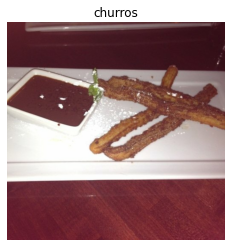

In [52]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"{classes[int(label)]}")
plt.axis("off")

#**Preprocessing Image**

In [53]:
def preprocess_image(image, label, img_size=300):
    image=tf.image.resize(image, size=[img_size, img_size])
    # image=image/255 #rescale image not needed for efficient net architecture
    return tf.cast(image, tf.float32), label

#**Callbacks**

In [54]:
def tensorboard_callback(file_path):
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    print("saving tensorboard logs to:",file_path)
    return tensorboard_callback

def checkpoint_callback(file_path):
    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                           monitor="val_loss",
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=0)
    print("saving checkpoint callbacks to:",file_path)
    return checkpoint_callback
  
def early_stopping():
  early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=3) 
  return early_stopping
  
def reduce_lr():
  reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   factor=0.1,
                                                   patience=2,
                                                   verbose=1,
                                                   min_lr=1e-4)
  return reduce_lr

#**Setting up data processors_to fasten loading** 

In [55]:
train_data=train_data.map(map_func= preprocess_image, 
                          num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size=32)

test_data=test_data.map(map_func= preprocess_image, 
                          num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size=32)

#**Mixed precision**

In [56]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="float32")

#**Model_1**: Feature extract

In [57]:
from tensorflow.keras.layers.experimental import preprocessing

In [58]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

mixed_precision.set_global_policy(policy="mixed_float16")

data_aug=tf.keras.Sequential([preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                     preprocessing.RandomRotation(0.2),
                                     ])

inputs=tf.keras.layers.Input((300,300,3))

# x=data_aug(inputs) takes a lot of time
x=base_model(inputs)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101, activation="softmax", dtype=tf.float32)(x)

model_1=tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

In [59]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [60]:
for layer in model_1.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_6 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "float32">


In [61]:
for layer in model_1.layers[1].layers[:15]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_5 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "float32">
normalization_2 False float32 <Policy "float32">
tf.math.truediv_2 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">


In [62]:
history_1=model_1.fit(train_data,
                      epochs=5,
                      validation_data=(test_data),
                      validation_steps=int(0.1*len(test_data)),
                      callbacks=[tensorboard_callback("tensorboard/model_1"),
                                 checkpoint_callback("checkpoint/model_1_0to5")],
                      )

saving tensorboard logs to: tensorboard/model_1
saving checkpoint callbacks to: checkpoint/model_1_0to5
Epoch 1/5
2368/2368 [==============================] - 302s 125ms/step - loss: 1.7174 - accuracy: 0.5849 - val_loss: 1.0829 - val_accuracy: 0.7124
Epoch 2/5
2368/2368 [==============================] - 297s 125ms/step - loss: 1.1954 - accuracy: 0.6901 - val_loss: 0.9534 - val_accuracy: 0.7433
Epoch 3/5
2368/2368 [==============================] - 297s 125ms/step - loss: 1.0587 - accuracy: 0.7244 - val_loss: 0.9020 - val_accuracy: 0.7484
Epoch 4/5
2368/2368 [==============================] - 296s 125ms/step - loss: 0.9719 - accuracy: 0.7431 - val_loss: 0.8756 - val_accuracy: 0.7615
Epoch 5/5
2368/2368 [==============================] - 296s 125ms/step - loss: 0.9093 - accuracy: 0.7581 - val_loss: 0.8681 - val_accuracy: 0.7607


In [63]:
model_1.evaluate(test_data)

790/790 [==============================] - 94s 119ms/step - loss: 0.8703 - accuracy: 0.7596


[0.8703265190124512, 0.7596039772033691]

#**Model_2(extension of model_1)**: Fine tuning

In [64]:
base_model.trainable=True
for layer in base_model.layers[:-75]:
    layer.trainable=False
    
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

In [65]:
history_2=model_1.fit(train_data,
                      epochs=100,
                      initial_epoch=history_1.epoch[-1],
                      validation_data=(test_data),
                      validation_steps=int(0.1*len(test_data)),
                      callbacks=[tensorboard_callback("tensorboard/model_2"),
                                 checkpoint_callback("checkpoint/model_1_5to10"),
                                 reduce_lr(),
                                 early_stopping()],
                      )

saving tensorboard logs to: tensorboard/model_2
saving checkpoint callbacks to: checkpoint/model_1_5to10
Epoch 5/100
2368/2368 [==============================] - 403s 167ms/step - loss: 1.1520 - accuracy: 0.6939 - val_loss: 0.7441 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - 396s 167ms/step - loss: 0.7770 - accuracy: 0.7878 - val_loss: 0.7550 - val_accuracy: 0.7975 - lr: 0.0010
Epoch 7/100
2368/2368 [==============================] - 397s 168ms/step - loss: 0.5848 - accuracy: 0.8341 - val_loss: 0.7241 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 8/100
2368/2368 [==============================] - 397s 167ms/step - loss: 0.4401 - accuracy: 0.8716 - val_loss: 0.7299 - val_accuracy: 0.8093 - lr: 0.0010
Epoch 9/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.9014
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2368/2368 [==============================] - 396s 167ms/step - loss: 0.

In [71]:
model_1.evaluate(test_data)

790/790 [==============================] - 98s 124ms/step - loss: 0.6604 - accuracy: 0.8528


[0.6603772640228271, 0.8527524471282959]

#**Plotting the loss curves**

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def history_plot(his):
    
    epochs=np.arange(len(his.history["loss"]))
    plt.figure(figsize=(10,7))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, his.history["loss"], label="train_loss")
    plt.plot(epochs, his.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, his.history["accuracy"], label="train_accuracy")
    plt.plot(epochs, his.history["val_accuracy"], label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

In [73]:
import pandas as pd

**Plots of model before finetuning**

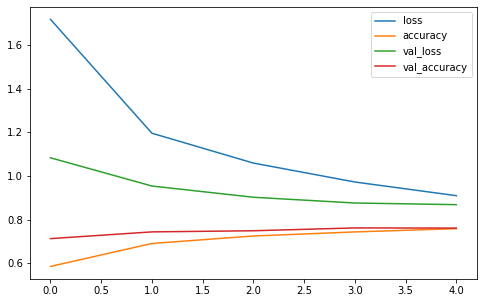

In [67]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))

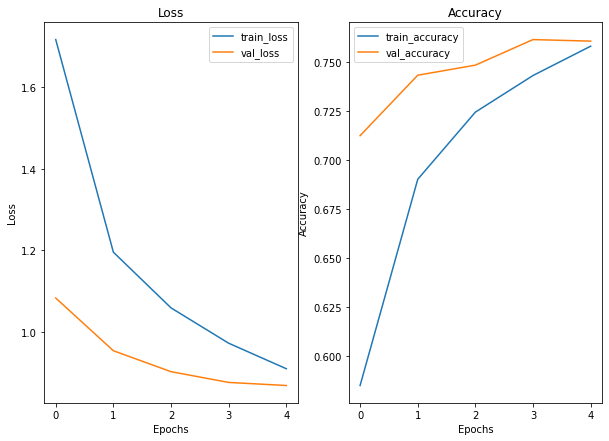

In [68]:
history_plot(history_1)

**Plots after fine tuning**

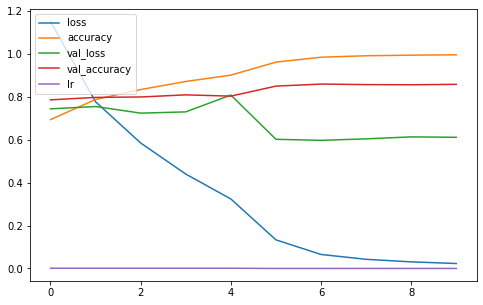

In [69]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))

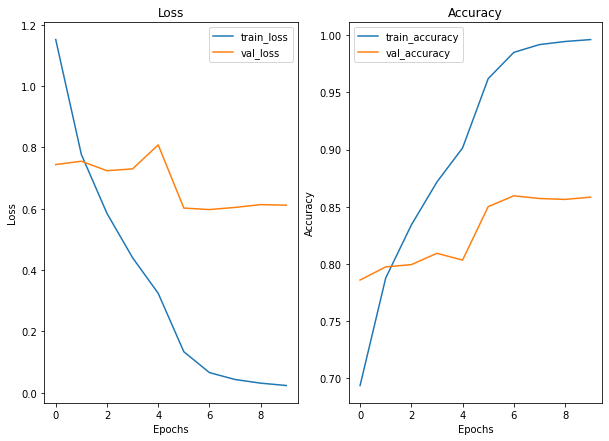

In [70]:
history_plot(history_2)

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
def load_prep_image(filepath):
  img=tf.io.read_file(filepath)
  img=tf.io.decode_image(img)
  img=tf.image.resize(img,[300,300])
  return img

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/pizza.jpg
1/1 [==============================] - 2s 2s/step


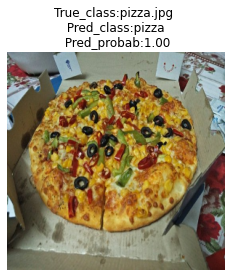

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/chocolate_cake.jpg
1/1 [==============================] - 0s 25ms/step


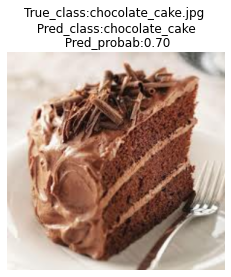

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/donut.jpg
1/1 [==============================] - 0s 25ms/step


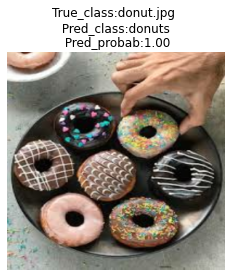

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/french_toast.jpg
1/1 [==============================] - 0s 25ms/step


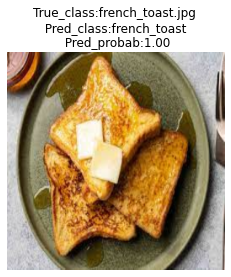

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/ice_cream.jpg
1/1 [==============================] - 0s 24ms/step


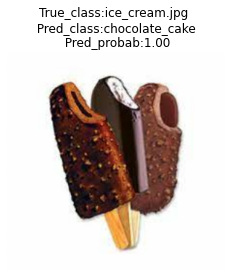

/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images/samosa.jpg
1/1 [==============================] - 0s 27ms/step


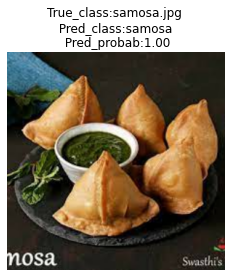

In [76]:
import os
for image in os.listdir("/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images"):
  img_path="/content/drive/MyDrive/ML/DL/CV/Multi_class/custom_images"+"/"+image
  print(img_path)
  img=load_prep_image(img_path)
  y_p=model_1.predict(tf.expand_dims(img, axis=0))
  plt.imshow(img/255)
  plt.title(f"True_class:{image} \n Pred_class:{classes[y_p.argmax()]} \n Pred_probab:{y_p.max():.2f}")
  plt.axis(False)
  plt.show()

In [77]:
!tensorboard dev upload --logdir ./tensorboard/\
--name "Food_101_FullScale"\
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=HDS5a5d4XWsPCfIXOILS9IoMtsEIzH&prompt=consent&access_type=offlin

#**TensorBoard Results**:https://tensorboard.dev/experiment/0gAkoZHgTni3fYgHx39kyw/